https://www.youtube.com/watch?v=eEGbTd7AG9s

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, Merge, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler

%matplotlib inline

Description of the data:

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [7]:
rides = pd.read_csv('hour.csv')
rides['time'] = pd.to_datetime(rides['dteday'])+pd.Series([pd.DateOffset(hours = a ) for a in rides.hr.tolist()])
rides.drop(['instant','yr','dteday','casual','registered', 'atemp'],1,inplace=True)
rides['t'] = rides.time.values.astype(float)
rides.head()

/Users/sachin/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:539: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18
1,1,1,1,0,6,0,1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18
2,1,1,2,0,6,0,1,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18
3,1,1,3,0,6,0,1,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18


Get **one hot encoded** values of the categorical variables:

In [8]:
cat_features = ['season', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
rides = pd.get_dummies(rides, columns=cat_features)
rides.head()

,temp,hum,windspeed,cnt,time,t,season_1,season_2,season_3,season_4,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0


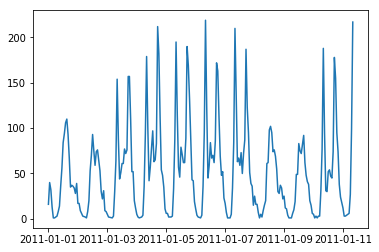

In [9]:
plt.plot(rides.time[:240],rides.cnt[:240])
plt.show()

In [10]:
quant_features = ['temp', 'hum', 'windspeed','t']
x_scaler = StandardScaler()
rides[quant_features] = x_scaler.fit_transform(rides[quant_features].values)

y_scaler = StandardScaler()
rides['cnt'] = y_scaler.fit_transform(rides['cnt'].values[:,None])

rides.head()

/Users/sachin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


,temp,hum,windspeed,cnt,time,t,season_1,season_2,season_3,season_4,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0


## Initial model (1 hidden layer with Relu activations)

Split data into testing and training

In [11]:
train_data = rides[:-21*24]
test_data = rides[-21*24:]

train_x = train_data.drop(['cnt','time'],axis=1).values
test_x = test_data.drop(['cnt','time'],axis=1).values

In [12]:
train_x.shape

(16875, 59)

In [13]:
model = Sequential()
model.add(Dense(train_x.shape[1]//2,input_dim=train_x.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')

In [14]:
# Train the model
model.fit(train_x, train_data['cnt'], batch_size=256, epochs=11)

Epoch 1/11
16875/16875 [==============================] - 0s - loss: 0.8676     
Epoch 2/11
16875/16875 [==============================] - 0s - loss: 0.6291     
Epoch 3/11
16875/16875 [==============================] - 0s - loss: 0.4790     
Epoch 4/11
16875/16875 [==============================] - 0s - loss: 0.3694     
Epoch 5/11
16875/16875 [==============================] - 0s - loss: 0.3032     
Epoch 6/11
16875/16875 [==============================] - 0s - loss: 0.2589     
Epoch 7/11
16875/16875 [==============================] - 0s - loss: 0.2256     
Epoch 8/11
16875/16875 [==============================] - 0s - loss: 0.2027     
Epoch 9/11
16875/16875 [==============================] - 0s - loss: 0.1857     
Epoch 10/11
16875/16875 [==============================] - 0s - loss: 0.1722     
Epoch 11/11
16875/16875 [==============================] - 0s - loss: 0.1608     


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                1740      
_________________________________________________________________
activation_1 (Activation)    (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 1,770.0
Trainable params: 1,770.0
Non-trainable params: 0.0
_________________________________________________________________


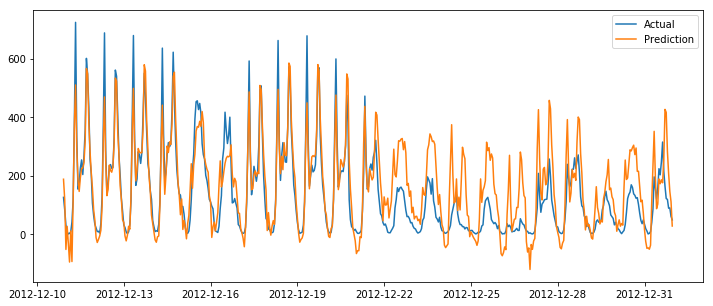

In [16]:
pred_y = model.predict(test_x, batch_size=256)
plt.figure(figsize=(12,5))
plt.plot(test_data.time, y_scaler.inverse_transform(test_data.cnt), label='Actual')
plt.plot(test_data.time, y_scaler.inverse_transform(pred_y), label='Prediction')
plt.legend()
plt.show()

In [17]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.23559209562483288

In [18]:
#! pip install graphviz
#! pip install pydot-ng

Uncomment the pip commands above if you want to get the image below. i.e. If the command below chucks an error uncomment the commands above.

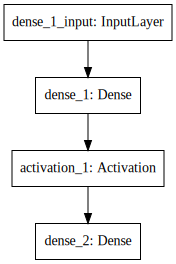

In [19]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                1740      
_________________________________________________________________
activation_1 (Activation)    (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 1,770.0
Trainable params: 1,770.0
Non-trainable params: 0.0
_________________________________________________________________


## Two Layer hidden network

In [22]:
train_x.shape

(16875, 59)

In [23]:
h_nodes = [40, 20]
model = Sequential()

# The two hidden layers (first layer needs the dimensions of x)
model.add(Dense(h_nodes[0],input_dim=train_x.shape[1]))
model.add(Activation(relu))
model.add(Dense(h_nodes[1]))
model.add(Activation('relu'))

model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')
model.fit(train_x, train_data['cnt'], batch_size=256, epochs=11)

Epoch 1/11
16875/16875 [==============================] - 0s - loss: 0.9595     
Epoch 2/11
16875/16875 [==============================] - 0s - loss: 0.5774     
Epoch 3/11
16875/16875 [==============================] - 0s - loss: 0.4192     
Epoch 4/11
16875/16875 [==============================] - 0s - loss: 0.3131     
Epoch 5/11
16875/16875 [==============================] - 0s - loss: 0.2526     
Epoch 6/11
16875/16875 [==============================] - 0s - loss: 0.2160     
Epoch 7/11
16875/16875 [==============================] - 0s - loss: 0.1889     
Epoch 8/11
16875/16875 [==============================] - 0s - loss: 0.1678     
Epoch 9/11
16875/16875 [==============================] - 0s - loss: 0.1496     
Epoch 10/11
16875/16875 [==============================] - 0s - loss: 0.1345     
Epoch 11/11
16875/16875 [==============================] - 0s - loss: 0.1217     


In [24]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.25022489731273956

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 40)                2400      
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 3,241.0
Trainable params: 3,241.0
Non-trainable params: 0.0
_________________________________________________________________


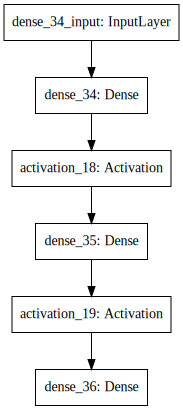

In [62]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Best Hyper parameters

In [1]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/eEGbTd7AG9s?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [26]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

What is Cross Validation?
https://stats.stackexchange.com/questions/1826/cross-validation-in-plain-english

In [27]:
# import keras.backend as K

def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=train_x.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1)) # Note: no activation beyond this point
    
    model.compile(optimizer='adadelta', loss='mse')
    return model
    
model = KerasRegressor(build_fn=create_model, verbose=0)    

In [34]:
layers = [[30], [40, 20], [45, 30, 15]]
activations = [sigmoid, relu]
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error')

In [35]:
grid_result = grid.fit(train_x, train_data['cnt'].values)

In [38]:
[grid_result.best_score_, grid_result.best_params_]

[-0.13536392705699826,
 {'activation': <function keras.activations.relu>,
  'batch_size': 128,
  'epochs': 30,
  'layers': [45, 30, 15]}]

In [39]:
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

-0.354904 (0.155346) with: {'batch_size': 128, 'layers': [30], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.327239 (0.149877) with: {'batch_size': 128, 'layers': [40, 20], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.316260 (0.161740) with: {'batch_size': 128, 'layers': [45, 30, 15], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.376903 (0.187427) with: {'batch_size': 256, 'layers': [30], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.350373 (0.192372) with: {'batch_size': 256, 'layers': [40, 20], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.371596 (0.221870) with: {'batch_size': 256, 'layers': [45, 30, 15], 'activation': <function sigmoid at 0x112e911e0>, 'epochs': 30}
-0.172043 (0.052121) with: {'batch_size': 128, 'layers': [30], 'activation': <function relu at 0x112e910d0>, 'epochs': 30}
-0.152897 (0.074760) with: {'batch_size': 128, 'layers': [40, 20], 'activation': <function relu a

/Users/sachin/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Finally predict the values on the actual test set with given params:

In [48]:
pred_y = grid.predict(test_x)

In [53]:
error = test_data['cnt'] - pred_y
np.mean(np.square(error))

0.12697137067941835